Imports that will be used to construct the model.

In [3]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.layers import Input, Dense
from keras.models import Model,Sequential
from tensorflow.keras.optimizers import Adam
from keras.layers import * 
from tensorflow_addons.layers import InstanceNormalization
from glob import glob
import os



Set Configs

In [4]:

IMG_WIDTH = 128
IMG_HEIGHT = 128
dataset_name = 'database2'

#DOWNLOAD_URL = 'https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/{}.zip'.format(dataset_name)



Generators using the U-net architecture

In [5]:

def build_generator(img_shape,channels=3,num_filters=64):
    """U-Net Generator"""

    def upsample_block(incoming_layer,skip_input_layer,num_filters,kernel_size=4,dropout_rate=0):
        """Layers used during upsampling"""
        upsample_layer = UpSampling2D(size=2)(incoming_layer)
        upsample_layer = Conv2D(num_filters,kernel_size=kernel_size,strides=1,padding='same',activation='relu')(upsample_layer)
        if dropout_rate:
            upsample_layer = Dropout(dropout_rate)(upsample_layer)
            upsample_layer = BatchNormalization(momentum=0.8)(upsample_layer)
            upsample_layer = Concatenate()([upsample_layer, skip_input_layer])
        return upsample_layer   
    
    def downsample_block(incoming_layer,num_filters,kernel_size=4,batch_normalization=True):
        """Layers used during downsampling"""
        downsample_layer = Conv2D(num_filters,kernel_size=kernel_size,strides=2, padding='same')(incoming_layer)
        downsample_layer = LeakyReLU(alpha=0.2)(downsample_layer)
        if batch_normalization:
            downsample_layer = BatchNormalization(momentum=0.8)(downsample_layer)
        return downsample_layer

    # Image input
    input_layer = Input(shape=img_shape)
    # Downsampling
    down_sample_1 = downsample_block(input_layer,
    num_filters,
    batch_normalization=False)
    # rest of the downsampling blocks have batch_normalization=true
    down_sample_2 = downsample_block(down_sample_1, num_filters*2)
    down_sample_3 = downsample_block(down_sample_2, num_filters*4)
    down_sample_4 = downsample_block(down_sample_3, num_filters*8)
    down_sample_5 = downsample_block(down_sample_4, num_filters*8)
    down_sample_6 = downsample_block(down_sample_5, num_filters*8)
    down_sample_7 = downsample_block(down_sample_6, num_filters*8)
    # Upsampling blocks with skip connections
    upsample_1 = upsample_block(down_sample_7, down_sample_6,num_filters*8)
    upsample_2 = upsample_block(upsample_1, down_sample_5,num_filters*8)
    upsample_3 = upsample_block(upsample_2, down_sample_4,num_filters*8)
    upsample_4 = upsample_block(upsample_3, down_sample_3,num_filters*8)
    upsample_5 = upsample_block(upsample_4, down_sample_2,num_filters*2)
    upsample_6 = upsample_block(upsample_5, down_sample_1, num_filters)
    upsample_7 = UpSampling2D(size=2)(upsample_6)
    output_img = Conv2D(channels,kernel_size=4,strides=1,padding='same',activation='tanh')(upsample_7)
    return Model(input_layer, output_img)


Discriminator function

In [6]:
def build_discriminator(img_shape,num_filters=64):
    """ discrimitator block """
    def discriminator_block(incoming_layer,num_filters,kernel_size = 4,instance_normalization=True):
        disc_layer = Conv2D(num_filters,kernel_size=kernel_size,strides=2,padding='same')(incoming_layer)
        disc_layer = LeakyReLU(alpha = 0.2)(disc_layer)
        if instance_normalization:
            disc_layer = InstanceNormalization()(disc_layer)
        return disc_layer

    input_layer = Input(shape=img_shape)
    #first layer not normalized
    disc_block_1 = discriminator_block(input_layer,num_filters,instance_normalization=False)
    disc_block_2 = discriminator_block(disc_block_1, num_filters*2)
    disc_block_3 = discriminator_block(disc_block_2, num_filters*4)
    disc_block_4 = discriminator_block(disc_block_3, num_filters*8)
    output = Conv2D(1, kernel_size=4, strides=1, padding='same')(disc_block_4)
    
    return Model(input_layer, output)


GAN setup

In [7]:
generator_filters = 32
discriminator_filters = 64

# input shape
channels = 3
input_shape = (IMG_HEIGHT, IMG_WIDTH, channels)
# Loss weights
lambda_cycle = 10.0

lambda_identity = 0.1 * lambda_cycle
optimizer = Adam(0.0002, 0.5)

# prepare patch size for our setup
patch = int(IMG_HEIGHT / 2**4)
patch_gan_shape = (patch, patch, 1)
print("Patch Shape={}".format(patch_gan_shape))

# Discriminators
disc_A = build_discriminator(input_shape,discriminator_filters)
disc_A.compile(loss='mse',optimizer=optimizer,metrics=['accuracy'])
disc_B = build_discriminator(input_shape,discriminator_filters)
disc_B.compile(loss='mse',optimizer=optimizer,metrics=['accuracy'])

# Generators
gen_AB = build_generator(input_shape,channels, generator_filters)
gen_BA = build_generator(input_shape, channels, generator_filters)

# CycleGAN
img_A = Input(shape=input_shape)
img_B = Input(shape=input_shape)

# generate fake samples from both generators
fake_B = gen_AB(img_A)
fake_A = gen_BA(img_B)

# reconstruct original samples from both generators
reconstruct_A = gen_BA(fake_B)
reconstruct_B = gen_AB(fake_A)

# generate identity samples
identity_A = gen_BA(img_A)
identity_B = gen_AB(img_B)

# disable discriminator training
disc_A.trainable = False
disc_B.trainable = False

# use discriminator to classify real vs fake
output_A = disc_A(fake_A)
output_B = disc_B(fake_B)

# Combined model trains generators to fool discriminators
gan = Model(inputs=[img_A, img_B],
outputs=[output_A, output_B,reconstruct_A, reconstruct_B,identity_A, identity_B ])

gan.compile(loss=['mse', 'mse','mae', 'mae','mae', 'mae'],loss_weights=[1, 1,lambda_cycle, lambda_cycle,lambda_identity, lambda_identity ],optimizer=optimizer)


Patch Shape=(8, 8, 1)


Function that generates a batch of images

In [8]:
def batch_generator(path,
                    batch_size=1,
                    image_res=[128, 128],
                    is_testing=False):
    """
    Method to generate batch of images
    Parameters:
        path: type:str. Path to the dataset
        batch_size: type:int. Number of images required
        image_res: type:int list. Array denoting the resized [H,W] of image
        is_testing: type: bool. Flag to control random flipping
    Returns:
        yields a tuple of two lists (source,target)
    """
    data_type = "train" if not is_testing else "test"
    path_A = [os.path.normpath(i) for i in glob('{}/{}A/*'.format(path, data_type))]
    path_B = [os.path.normpath(i) for i in glob('{}/{}B/*'.format(path, data_type))]

    num_batches = int(min(len(path_A), len(path_B)) / batch_size)
    num_samples = num_batches * batch_size

    # get num_samples from each domain
    path_A = np.random.choice(path_A, num_samples, replace=False)
    path_B = np.random.choice(path_B, num_samples, replace=False)

    for i in range(num_batches-1):
        batch_A = path_A[i*batch_size:(i+1)*batch_size]
        batch_B = path_B[i*batch_size:(i+1)*batch_size]
        imgs_A, imgs_B = [], []
        for img_A, img_B in zip(batch_A, batch_B):
            img_A = imread(img_A, image_res)
            img_B = imread(img_B, image_res)

            if not is_testing and np.random.random() > 0.5:
                img_A = np.fliplr(img_A)
                img_B = np.fliplr(img_B)

            imgs_A.append(img_A)
            imgs_B.append(img_B)

        imgs_A = np.array(imgs_A)
        imgs_B = np.array(imgs_B)

        yield imgs_A, imgs_B


Training loop

In [9]:
def train(gen_AB,gen_BA,disc_A,disc_B,gan,patch_gan_shape,epochs,
            path='C:/content/{}'.format(dataset_name),batch_size=1,sample_interval=50):

    # Adversarial loss ground truths
    real_y = np.ones((batch_size,) + patch_gan_shape)
    fake_y = np.zeros((batch_size,) + patch_gan_shape)
    for epoch in range(epochs):
        print("Epoch={}".format(epoch))
        for idx, (imgs_A, imgs_B) in enumerate(batch_generator(path,batch_size,image_res=[IMG_HEIGHT, IMG_WIDTH])):
            
            # train discriminators
            # generate fake samples from both generators
            fake_B = gen_AB.predict(imgs_A)
            fake_A = gen_BA.predict(imgs_B)
            # Train the discriminators
            # (original images = real / translated = Fake)
            disc_A_loss_real = disc_A.train_on_batch(imgs_A, real_y)
            disc_A_loss_fake = disc_A.train_on_batch(fake_A, fake_y)
            disc_A_loss = 0.5 * np.add(disc_A_loss_real,disc_A_loss_fake)

            disc_B_loss_real = disc_B.train_on_batch(imgs_B, real_y)
            disc_B_loss_fake = disc_B.train_on_batch(fake_B, fake_y)
            disc_B_loss = 0.5 * np.add(disc_B_loss_real,disc_B_loss_fake)
            
            # Total disciminator loss
            discriminator_loss = 0.5 * np.add(disc_A_loss, disc_B_loss)

            # train generator
            gen_loss = gan.train_on_batch([imgs_A, imgs_B],[real_y, real_y,imgs_A, imgs_B,imgs_A, imgs_B])

            # training updates every 50 iterations
            if idx % 50 == 0:
                print ("[Epoch {}/{}] [Discriminator loss: {}, accuracy:{}][Generator loss: {}, Adversarial Loss: {}, Reconstruction Loss: {},Identity Loss: {}]".format(idx,epochs,discriminator_loss[0],100*discriminator_loss[1],
                        gen_loss[0],np.mean(gen_loss[1:3]),np.mean(gen_loss[3:5]),np.mean(gen_loss[5:6])))
        
            # Plot and Save progress every few iterations
            if idx % sample_interval == 0:
                plot_sample_images(gen_AB,gen_BA,path=path,epoch=epoch,batch_num=idx,output_dir='images')



DL dataset

In [8]:
tf.keras.utils.get_file('{}.tar.gz'.format(dataset_name),
                         origin=DOWNLOAD_URL,
                         cache_subdir='/content',
                         extract=True)

'C:/content\\apple2orange.tar.gz'

Begin training

In [10]:
def plot_sample_images(gen_AB,
                       gen_BA,
                       path,
                       epoch=0,
                       batch_num=1,
                       output_dir='maps'):
    """
    Method to plot sample outputs from generator
    Parameters:
        g_AB        :   type:keras model object. Generator model from A->B
        gen_BA      :   type:keras model object. Generator model from B->A
        path        :   type:str. Path to dataset
        epoch       :   type:int. Epoch number, used for output file name
        batch_num   :   type:int. Batch number, used for output file name
        output_dir  :   type:str. Path to save generated output samples
    Returns:
        None
    """
    imgs_A = get_samples(path, domain="A", batch_size=1, is_testing=True)
    imgs_B = get_samples(path, domain="B", batch_size=1, is_testing=True)

    # generate fake samples from both generators
    fake_B = gen_AB.predict(imgs_A)
    fake_A = gen_BA.predict(imgs_B)

    # reconstruct orginal samples from both generators
    reconstruct_A = gen_BA.predict(fake_B)
    reconstruct_B = gen_AB.predict(fake_A)

    gen_imgs = np.concatenate([imgs_A, fake_B,
                               reconstruct_A,
                               imgs_B, fake_A,
                               reconstruct_B])

    # scale images 0 - 1
    gen_imgs = 0.5 * gen_imgs + 0.5

    os.makedirs(output_dir, exist_ok=True)
    titles = ['Original', 'Translated', 'Reconstructed']

    r, c = 2, 3
    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
      for j in range(c):
          axs[i,j].imshow(gen_imgs[cnt])
          axs[i, j].set_title(titles[j])
          axs[i,j].axis('off')
          cnt += 1
    fig.savefig("{}/{}_{}.png".format(output_dir, epoch, batch_num))
    plt.show()
    plt.close()


In [11]:
def get_samples(path,
                domain='A',
                batch_size=1,
                image_res=[128, 128],
                is_testing=False):
    """
    Method to get a random sample of images
    Parameters:
        path        : type:str. Path to the dataset
        domain: type:str. Domain A or B to pick samples from.
        batch_size  : type:int. Number of images required
        image_res   : type:int list. Array denoting the resized [H,W] of image
        is_testing  : type: bool. Flag to control random flipping
    Returns:
        A list of randomly sampled images
    """
    data_type = "train%s" % domain if not is_testing else "test%s" % domain
    path = [os.path.normpath(i) for i in glob('{}/{}/*'.format(path, data_type))]

    random_sample = np.random.choice(path, size=batch_size)

    imgs = []
    for img_path in random_sample:
        img = imread(img_path, image_res)
        if not is_testing and np.random.random() > 0.5:
            img = np.fliplr(img)
        imgs.append(img)

    return np.array(imgs)

In [18]:
def imread(path, image_res=[128, 128]):
    """
    Utility to read image in RGB format and normalize it
    Parameters:
        path        : type:list. Path to the image to be loaded
        image_res   : type:int list. Array denoting the resized [H,W] of image
    Returns:
        A normalized and resized image
    """
    img = plt.imread(path, format='RGB').astype(np.float64)
    
    print(img.shape)
    if len(img.shape) == 2:
        img = np.stack((img, img, img), axis=2)
        img = tf.image.resize(img, image_res, preserve_aspect_ratio=True).numpy()
        img = img * 2. - 1
        
    else:
        img = tf.image.resize(img, image_res, preserve_aspect_ratio=True).numpy()
        img = img/127.5 - 1
        
    
    return img


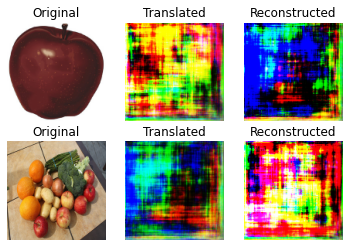

In [19]:
plot_sample_images(gen_AB, gen_BA, 'C:/content/apple2orange')

In [ ]:
train(gen_AB,gen_BA,disc_A,disc_B,gan,patch_gan_shape,5)